# Morarach et al. Paper 

This paper aimed to identify the neuronal diversity of the enteric nervous system. Neurons from the myenteric plexus of the small intestines were taken from post-natal day 21 (P21) Baf53b-Cre mice, where single-cell RNA-sequencing was then performed. Morarach et al. sought to visualize the genetic similarities of individual samples through UMAP dimension reduction. They used Seurat (v.3.1.4) while we use Scanpy.

**Outlined are the steps they took to pre-process their data:**
1. Filter 9,141 cells based on three quality covariates: # UMI counts per cell, # genes per cell, fraction of counts from mitochondrial genes per cell.
    1. Cells with <1,500 genes and >8,000 genes are removed
    2. Cells with >60,000 UMI counts are excluded to mitigate potential doublets
    3. Cells with fraction of counts from mitochondrial genes of <0.1 (cells with <4,000 genes) and <0.25 (cells with >4,000 genes) are removed to account for injured cells
2. Normalization with regularized negative binomial regression method; SCTransform(). Contribution from MT gene counts are regressed out and 3,000 variable genes are retained.
3. Sex-specific (Xist, Gm13305, Tsix, Eif2534, Ddx3y, Uty) and immediate early genes (Fos, Jun, Junb, Egr1) are removed from the variable genes before PCA.
4. Preliminary clustering with permissive parameters to identify and remove low quality and non-enteric clusters.
5. kNN graph in 50 PCs space.
6. Leiden algorithm with resolution = 1.5.
7. Remove clusters with high expression of Pip1 and Elavl4 (neuron-glia contamination), low UMI counts per cells, and high fraction of mitochondrial genes.
8. Remaining cells are subject to second-level clustering (35 PCs, resolution = 1.0), yielding clear separation of glia and neuron clusters.
9. Only neuron clusters (4,892 cells total) are retained for third-level clustering (30 PCs, resolution = 0.4), yielding 12 final neuron clusters.
10. Clusters are visualized via UMAP (minimum distance = 0.5, n_neighbors = 30).

## Imports 

In [13]:
import os
import pandas as pd
import numpy as np

In [14]:
import scanpy as sc
import warnings

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import phenograph

## Set-Up and Functions

In [17]:
# Some plotting settings from Setty Lab
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [18]:
def read_matrix_files(file_base, samples):
    """
    Takes a file base (string) and a list of samples
    Returns a dictionary with the sample name as the key and the corresponding Anndata object as value
    """
    sample_dict = dict()
    for sample in samples: 
        ad = sc.read(file_base + sample + matrix_suffix)
        
        # Scanpy expects cells x genes, GEO stores genes x cells
        ad = ad.transpose()
        
        # read in barcode and gene files, they are stored as tsvs
        barcodes = pd.read_csv(file_base + sample + barcode_suffix, header=None, sep='\t')
        genes = pd.read_csv(file_base + sample + gene_suffix, header=None, sep='\t')

        # Annotate data
        ad.obs_names = sample + '#' + ad.obs_names

        barcodes.rename(columns={0:'barcode'}, inplace=True)
        barcodes.set_index('barcode', inplace=True)
        ad.obs = barcodes
        
        if len(genes.columns) == 3:
            genes.rename(columns={0:'gene_ids', 1:'gene', 2: 'feature_types'}, inplace=True)
        if len(genes.columns) == 2:
            genes.rename(columns={0:'gene_ids', 1:'gene'}, inplace=True)
        else:
            genes.rename(columns={0:'gene'}, inplace=True)
        genes.set_index('gene', inplace=True)
        ad.var = genes

        # Add sample info to dictionary
        sample_dict[sample] = ad
        sample_dict[sample].var_names_make_unique()
        
        # Set the .obs['sample'] to the sample name
        sample_dict[sample].obs['sample'] = sample
        
    return sample_dict

In [19]:
def basic_metrics(samples, sample_dict):
    """
    Takes list of samples and dictionary of samples generated from the read_matrix_files function
    Returns a dictionary of barcodes from the samples with computed quality metrics
    """
    sample_cells = dict()
    for sample in samples:
        sample_cells[sample] = sample_dict[sample].obs_names
        ad = sample_dict[sample]
        ad.var['mt'] = ad.var_names.str.startswith('mt-')
        sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False)
    return sample_cells

In [20]:
def graph_qc(ad, THRESHOLDS=np.zeros(2)):
    """
    Take an Anndata object
    Display 3 QC graphs: molecules per cell, genes per cell, mitochondrial genes per cell
    """
    plt.figure()
    if all(i == 0 for i in THRESHOLDS):
        THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3, 98]))
    figs, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].hist(np.log10(ad.obs['total_counts']), 50)
    axs[0].set_xlabel('log10(nUMI/cell)')
    axs[0].set_ylabel('Frequency')
    
    axs[1].hist(ad.obs['n_genes_by_counts'], 50)
    axs[1].set_xlabel('nGenes/cell')
    axs[1].set_ylabel('Frequency')

    axs[2].hist(ad.obs['pct_counts_mt'], 50)
    axs[2].set_xlabel('% Mitochondrial genes /cell')
    axs[2].set_ylabel('Frequency')
    sns.despine()

In [21]:
def merge(samples, sample_dict, sample_cells):
    """
    Returns merged Anndata object of all the samples
    """
    sample = samples[0]
    ad = sample_dict[sample][sample_cells[sample]]
    for sample in samples[1:]:
        ad = ad.concatenate(sample_dict[sample][sample_cells[sample]], 
                                index_unique=None, batch_key='batch')
    ad.obs_names_make_unique()
    # Clean up var object
    ad.var = pd.DataFrame(index=ad.var_names)
    return ad

In [22]:
def cluster(ad, algorithm, num_neighbors, pcs, res, num_top_genes):
    """
    Selects the top n most variable genes, performs PCA on these genes, keeps n PCs, calculates kNN graph on n neighbors (default), and performs Leiden algorithm (res = 1.0 default)
    Returns updated AnnData object

    ad: AnnDataObject
    algorithm: str
    num_neighbors: int 
    pcs: int
    res: int
    num_top_genes: int
    """
    # calculate highly variable genes, keep top 1500
    sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=num_top_genes)
    
    # PCA using HVG
    sc.pp.pca(ad, use_highly_variable=True, n_comps=pcs)
    sc.pp.neighbors(ad, n_neighbors=num_neighbors, use_rep='X_pca')
    
    if algorithm == 'phenograph':
        # Phenograph
        ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
        ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)
        
    if algorithm == 'leiden':
        key = 'leiden_' + str(res)
        sc.tl.leiden(ad, resolution=res, key_added=key)
        
    return ad

## Load Data

In [93]:
#Set up file name definitions
sample_myenteric = ['P21_1', 'P21_2']
sample_colon = ['Mouse_Adult_Distal_Colon_1', 'Mouse_Adult_Distal_Colon_2', 'Mouse_Adult_Distal_Colon_3']
file_base1 = 'Raw data/Morarach-et-al_myenteric_neuron_classes/GSE149524_RAW/'
matrix_suffix = '_matrix.mtx'
barcode_suffix = '_barcodes.tsv'
gene_suffix = '_genes.tsv'

In [94]:
# 10X myenteric plexus of small intestine
myenteric_dict = read_matrix_files(file_base1, sample_myenteric)
myenteric_cells = basic_metrics(sample_myenteric, myenteric_dict)

## Visualize QC Info

<Figure size 400x400 with 0 Axes>

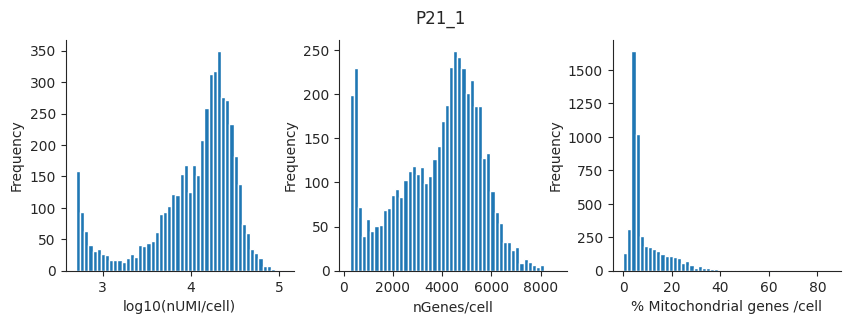

<Figure size 400x400 with 0 Axes>

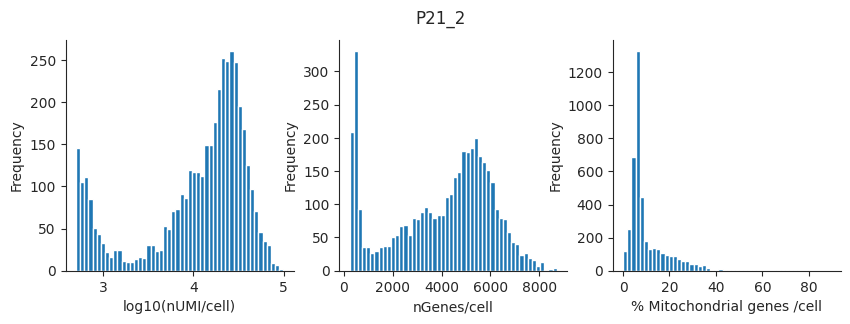

In [95]:
for sample in sample_myenteric:
    ad = myenteric_dict[sample]
    graph_qc(ad)
    plt.suptitle(sample)

## Filter 

In [96]:
# Myenteric plexus
# merge P21 replicates
myenteric_ad = merge(sample_myenteric, myenteric_dict, myenteric_cells)

/loc/scratch/59800171/ipykernel_32544/3024589798.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad = ad.concatenate(sample_dict[sample][sample_cells[sample]],
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [97]:
myenteric_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch
barcode,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0
...,...,...,...,...,...,...
TTTGTTGCAGGTGGAT-1,P21_2,3360,8858.0,1827.0,20.625423,1
TTTGTTGTCAGCACCG-1,P21_2,3096,8355.0,1395.0,16.696589,1
TTTGTTGTCAGGCGAA-1,P21_2,7274,59485.0,3658.0,6.149449,1


In [98]:
sc.pp.filter_genes(myenteric_ad, min_cells=5)

# remove cells with <1500 or > 8000 genes
sc.pp.filter_cells(myenteric_ad, min_genes=1500)
sc.pp.filter_cells(myenteric_ad, max_genes=8000)

# remove cells with >60000 UMI counts to remove potential doublets
myenteric_ad = myenteric_ad[myenteric_ad.obs['total_counts'] < 60000, :]

# remove cells with mt% > 25 for cells with >4000 genes, mt% > 10% for cells with <4000 genes
myenteric_ad = myenteric_ad[~((myenteric_ad.obs.pct_counts_mt > 25) & (myenteric_ad.obs.n_genes > 4000)), :]
myenteric_ad = myenteric_ad[~((myenteric_ad.obs.pct_counts_mt > 10) & (myenteric_ad.obs.n_genes < 4000)), :]

<Figure size 400x400 with 0 Axes>

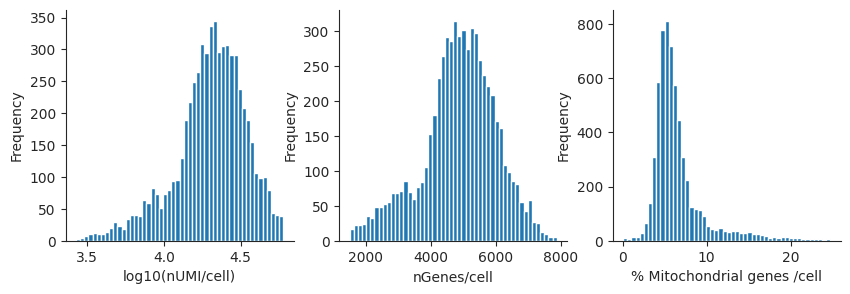

In [99]:
graph_qc(myenteric_ad)

In [100]:
myenteric_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes
barcode,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0,2888
...,...,...,...,...,...,...,...
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674
TTTGATCTCGGACAAG-1,P21_2,2057,4495.0,327.0,7.274750,1,2057
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224


In [101]:
myenteric_ad.var

,n_cells
gene,
Xkr4,1828
Gm1992,50
Mrpl15,5243
Lypla1,3877
Gm37988,37
...,...
AC132444.6,9
AC168977.1,24
PISD,6013


## Analysis

In [36]:
# # 15 PCs, k = 15, phenograph 
# #for each cell: median*((molecule count)/(total count))
# #sc.pp.normalize_per_cell(ss2_ad)
# sc.pp.normalize_total(ss2_ad, target_sum=1e4)
# sc.pp.log1p(ss2_ad)
# # check transformation
# print(ss2_ad.X.max())
# # Scale (z-score) expression of each gene across cells
# ss2_ad.layers['scaled'] = sc.pp.scale(ss2_ad, copy=True).X

In [37]:
# # 1500 HVGs, 30 comps, phenograph
# ss2_ad = cluster(ss2_ad, algorithm='leiden')

In [38]:
# sc.pl.highly_variable_genes(ss2_ad)

In [39]:
# #perplexity=20
# sc.tl.tsne(ss2_ad, perplexity=20)
# sc.tl.umap(ss2_ad)

In [40]:
# sc.pl.scatter(ss2_ad, basis='umap', color='total_counts', frameon=False)

In [165]:
#sc.pp.normalize_per_cell(mli_ad)
sc.pp.normalize_total(mli_ad, target_sum=1e4)
sc.pp.log1p(mli_ad)
print(mli_ad.X.max())
# Scale (z-score) expression of each gene across cells
mli_ad.layers['scaled'] = sc.pp.scale(mli_ad, copy=True).X

4.0447907


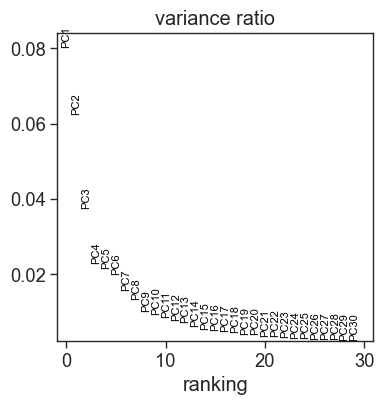

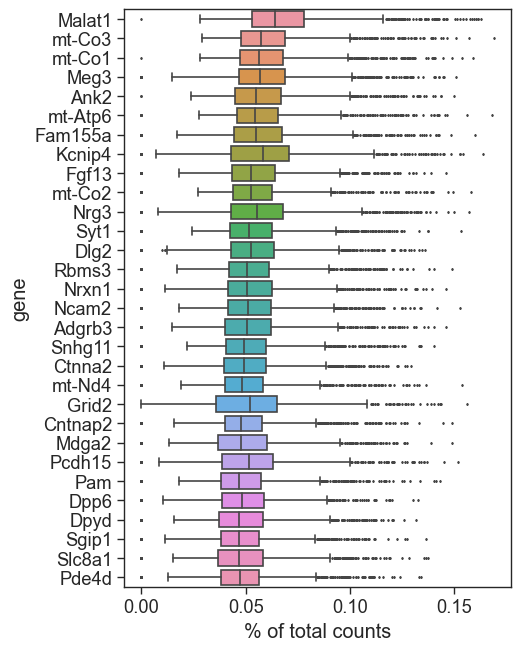

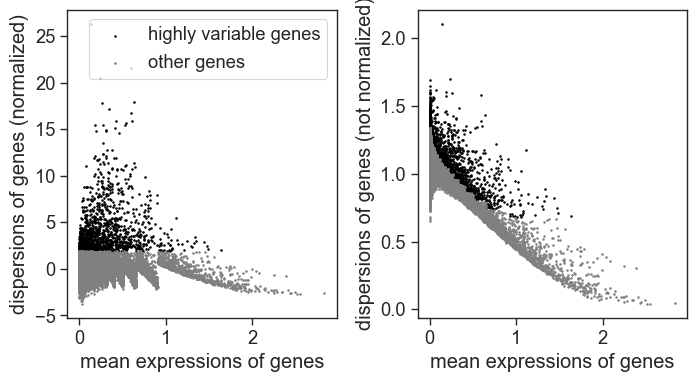

In [166]:
# 30 PCs, k = 25, phenograph
mli_ad = cluster(mli_ad, nk=25, pcs=30, genes=1500, algorithm='leiden')
sc.pl.pca_variance_ratio(mli_ad)
sc.pl.highest_expr_genes(mli_ad)

In [126]:
sc.tl.tsne(mli_ad, perplexity=20)
sc.tl.umap(mli_ad)

In [56]:
# 30 PCs, k = 10, phenograph 
sc.pp.normalize_per_cell(msi_ad)
sc.pp.log1p(msi_ad)
print(msi_ad.X.max())
msi_ad.layers['scaled'] = sc.pp.scale(msi_ad, copy=True).X

5.659691


In [57]:
msi_ad = cluster(msi_ad, nk=10, pcs=30, genes=1500, algorithm='phenograph')
sc.tl.tsne(msi_ad)
sc.tl.umap(msi_ad)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.007849931716918945 seconds
Jaccard graph constructed in 2.581740140914917 seconds
Wrote graph to binary file in 0.005671024322509766 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.81728
Louvain completed 21 runs in 0.5994479656219482 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.738316059112549 seconds


### Small intestine myenteric plexus

In [102]:
# Normalize and log transform
sc.pp.normalize_per_cell(myenteric_ad) # Note that the authors normalized using a different method

#log_transform(myenteric_ad)
sc.pp.log1p(myenteric_ad)

# Remove sex-specific and immediate early genes
sex_genes = ['Xist', 'Gm13305', 'Tsix', 'Eif253y', 'Ddx3y', 'Uty']
early = ['Fos', 'Jun', 'Junb', 'Egr1']

sex_genes_mk = np.in1d(myenteric_ad.var_names.values.astype(str), sex_genes)
myenteric_ad = myenteric_ad[:,~sex_genes_mk]

early_mk = np.in1d(myenteric_ad.var_names.values.astype(str), early)
myenteric_ad = myenteric_ad[:,~early_mk]

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:569: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [103]:
myenteric_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts
barcode,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0,2888,8800.0
...,...,...,...,...,...,...,...,...
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0
TTTGATCTCGGACAAG-1,P21_2,2057,4495.0,327.0,7.274750,1,2057,4495.0
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0


In [104]:
myenteric_ad.var 

,n_cells
gene,
Xkr4,1828
Gm1992,50
Mrpl15,5243
Lypla1,3877
Gm37988,37
...,...
AC132444.6,9
AC168977.1,24
PISD,6013


*Preliminary Cluster (permissive parameters)*  
Hana uses 30 PCs while I use 50

In [105]:
# Retain 3000 top genes
myenteric_ad = cluster(ad=myenteric_ad, algorithm='leiden', num_neighbors=10, pcs=50, res=1.5, num_top_genes=3000)
sc.tl.umap(myenteric_ad)

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


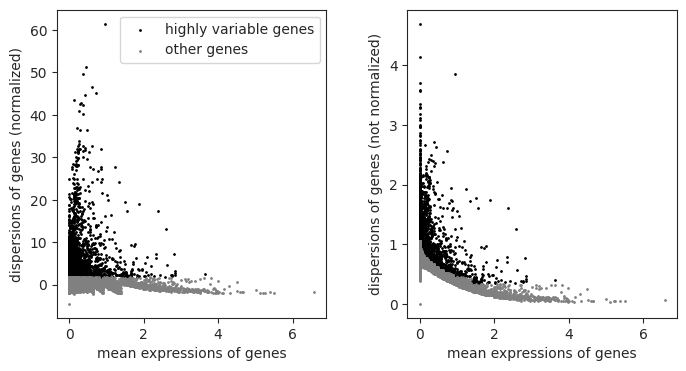

In [106]:
sc.pl.highly_variable_genes(myenteric_ad)

In [107]:
myenteric_ad.obs 

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5
barcode,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0,2888,8800.0,5
...,...,...,...,...,...,...,...,...,...
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2
TTTGATCTCGGACAAG-1,P21_2,2057,4495.0,327.0,7.274750,1,2057,4495.0,5
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4


In [108]:
# Sanity check
is_variable = myenteric_ad.var['highly_variable'] == True
myenteric_ad.var['highly_variable'][is_variable]

gene
Gm1992     True
Oprk1      True
St18       True
Adhfe1     True
Prex2      True
           ... 
Gfra1      True
Shtn1      True
Slc18a2    True
Gm7102     True
mt-Nd6     True
Name: highly_variable, Length: 3000, dtype: bool

In [58]:
# Mouse colon 10X
sc.pp.normalize_per_cell(colon_ad)
sc.pp.log1p(colon_ad)
colon_ad.layers['scaled'] = sc.pp.scale(colon_ad, copy=True).X

/Users/hmorris/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [59]:
colon_ad = cluster(colon_ad, pcs=11, genes=3000, algorithm='leiden')
sc.tl.umap(colon_ad)
sc.tl.tsne(colon_ad)

## Visualization

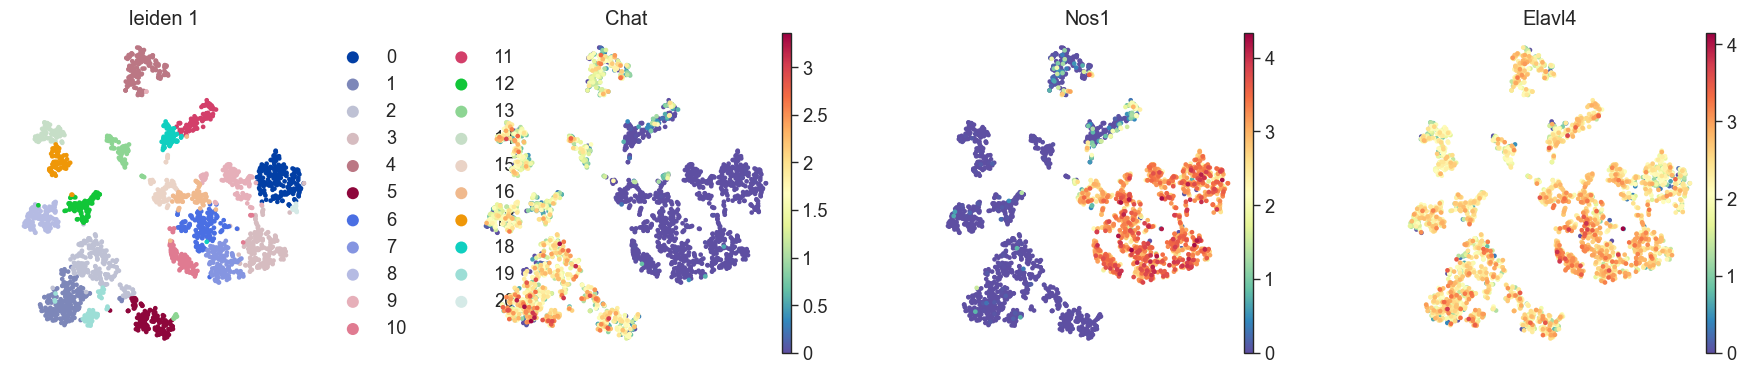

In [105]:
sc.pl.scatter(ss2_ad, basis='tsne', color=['leiden_1', 'Chat', 'Nos1', 'Elavl4'], frameon=False)

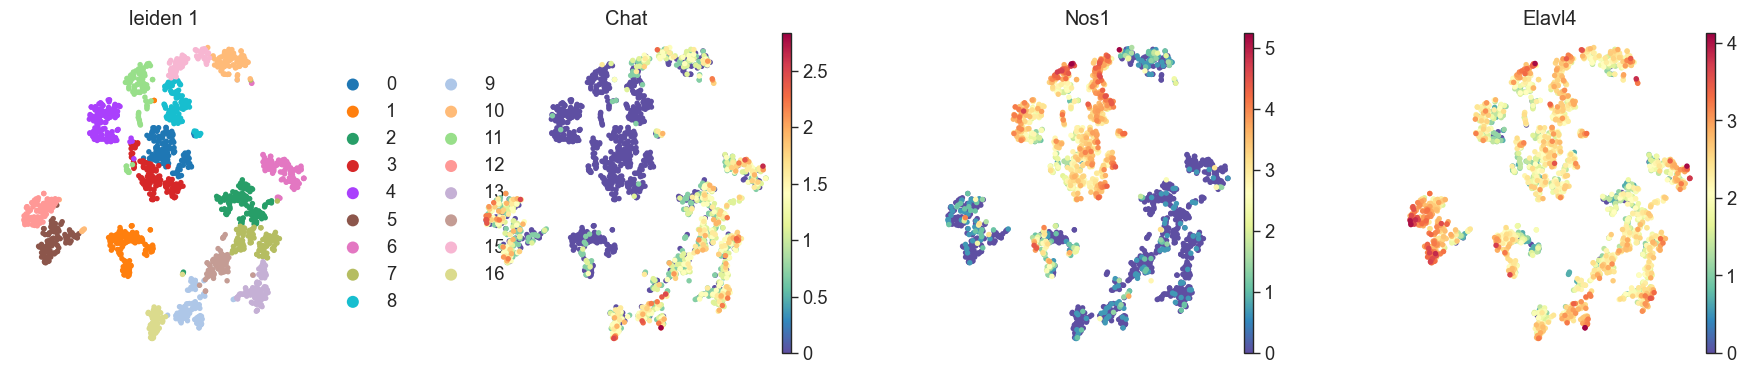

In [127]:
sc.pl.scatter(mli_ad, basis='tsne', color=['leiden_1', 'Chat', 'Nos1', 'Elavl4'], frameon=False)

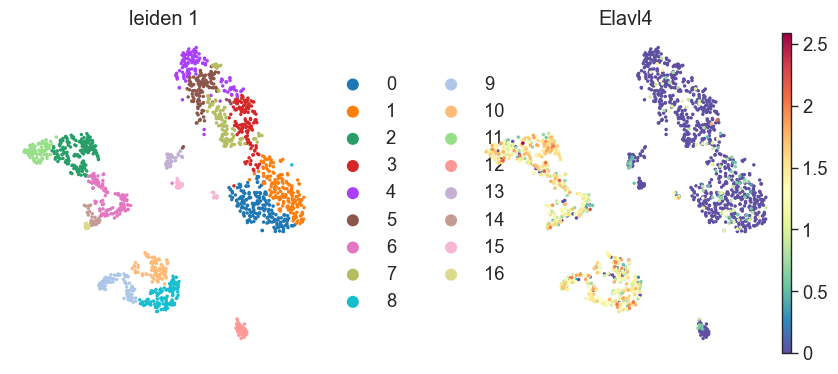

In [60]:
sc.pl.scatter(colon_ad, basis='tsne', size=25, color=['leiden_1', 'Elavl4'], frameon=False)

In [64]:
# remove glia
cn_ad = colon_ad[colon_ad.obs['leiden_1'].isin(['11', '2', '6', '14', '16', '9', '8', '10']),:].copy()

In [65]:
sc.pp.highly_variable_genes(cn_ad, flavor='cell_ranger', n_top_genes=1500)
sc.pp.neighbors(cn_ad, use_rep='X_pca')
sc.tl.umap(cn_ad)
cn_ad.obs['phenograph'], _, _ = phenograph.cluster(cn_ad.obsm['X_pca'])
cn_ad.obs['phenograph'] = cn_ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.006564140319824219 seconds
Jaccard graph constructed in 2.2525761127471924 seconds
Wrote graph to binary file in 0.008773088455200195 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.803802
Louvain completed 21 runs in 0.6244761943817139 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.060168981552124 seconds


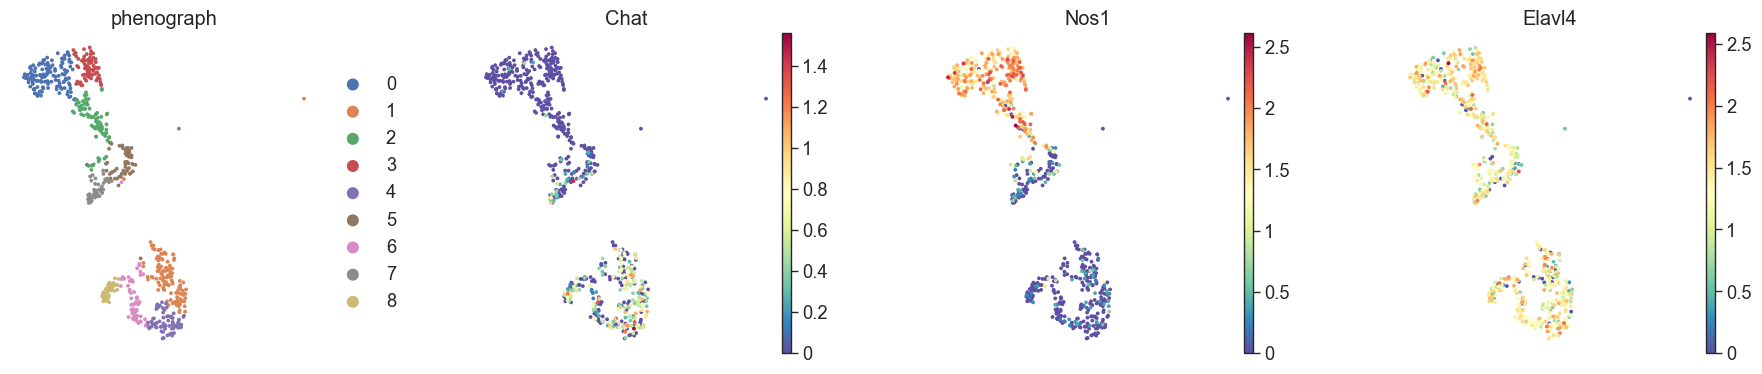

In [66]:
sc.pl.scatter(cn_ad, basis='tsne', size=30, color=['phenograph','Chat', 'Nos1', 'Elavl4'], frameon=False)

### Small Intestine

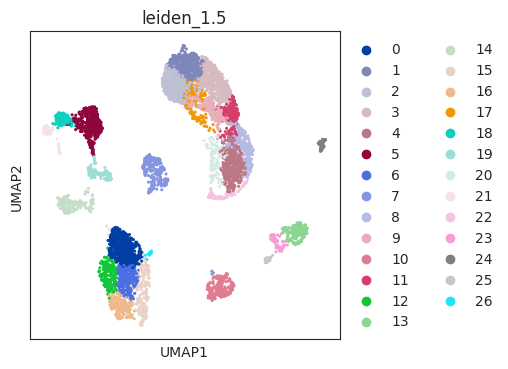

In [109]:
sc.pl.umap(myenteric_ad, color=['leiden_1.5'])

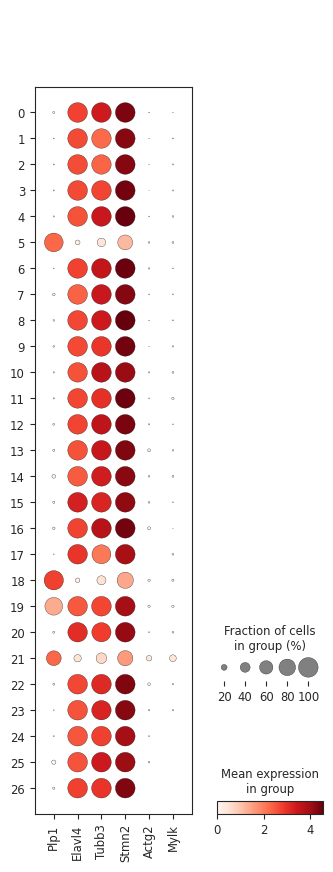

In [110]:
sc.pl.dotplot(myenteric_ad, ['Plp1', 'Elavl4', 'Tubb3', 'Stmn2', 'Actg2', 'Mylk'], 'leiden_1.5')

In [69]:
# myenteric_ad.obs.groupby('leiden_1.5')['pct_counts_mt'].describe()

In [111]:
# remove clusters with glia + neuron marker overlap
myenteric_clean = myenteric_ad[~myenteric_ad.obs['leiden_1.5'].isin(['5', '18']),:].copy()

<Figure size 400x400 with 0 Axes>

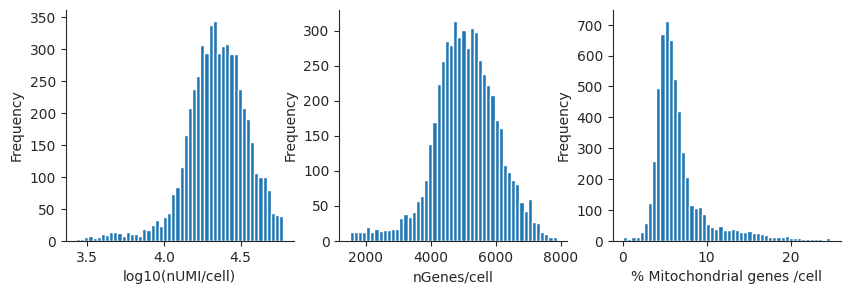

In [112]:
# Quality check
graph_qc(myenteric_clean)

In [113]:
sc.pp.highly_variable_genes(myenteric_clean, flavor='cell_ranger', n_top_genes=1500)

# PCA using HVG
sc.pp.pca(myenteric_clean, use_highly_variable=True, n_comps=35)
sc.pp.neighbors(myenteric_clean, use_rep='X_pca')
sc.tl.umap(myenteric_clean)
sc.tl.leiden(myenteric_clean) # res = 1.0

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [114]:
myenteric_clean.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden
barcode,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,6
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,8
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4
...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,19
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,3
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,0


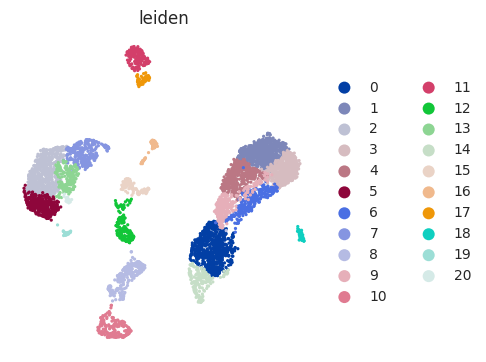

In [115]:
sc.pl.scatter(myenteric_clean, basis='umap', color=['leiden'], frameon=False)

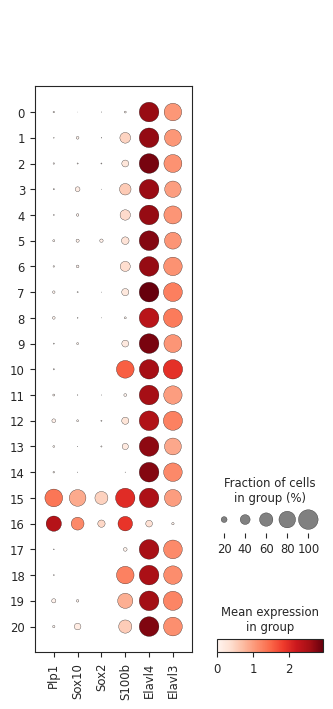

In [116]:
sc.pl.dotplot(myenteric_clean, ['Plp1', 'Sox10', 'Sox2', 'S100b', 'Elavl4', 'Elavl3'], 'leiden')

In [117]:
# remove glia
ad_mn = myenteric_clean[~myenteric_clean.obs['leiden'].isin(['15', '16']),:].copy()

In [118]:
ad_mn.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden
barcode,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,6
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,8
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4
...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,19
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,3
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,0


In [119]:
sc.pp.highly_variable_genes(ad_mn, flavor='cell_ranger', n_top_genes=1500)

# PCA using HVG
sc.pp.pca(ad_mn, use_highly_variable=True, n_comps=30)
sc.pp.neighbors(ad_mn, use_rep='X_pca')
sc.tl.umap(ad_mn)
sc.tl.leiden(ad_mn)
sc.tl.leiden(ad_mn, resolution = 0.4, key_added = "leiden_0.4")

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


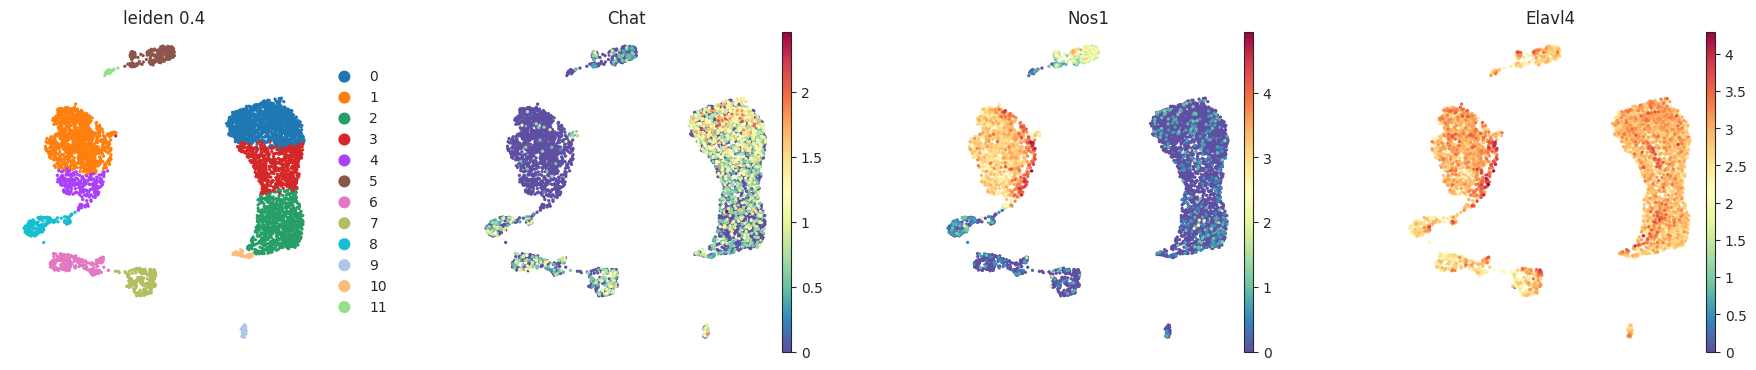

In [120]:
sc.pl.scatter(ad_mn, basis='umap', color=['leiden_0.4', 'Chat', 'Nos1', 'Elavl4'], frameon=False)

## Celltype Identification

### Marker Dictionaries

In [121]:
si_features_dict = {'Distinguishing': ['Tac1', 'Calb2', 'Ndufa4l2', 'Gda', 'Penk', 'Fut9', 'Nfatc1', 'Sst',
                                 'Nmu', 'Nog', 'Cck', 'Ucn3', 'C1ql1', 'Cox8b', 'Npy', 'Rprml', 'Neurod6',
                                 'Ntng1', 'Nxph2'],
               'Cholinergic': ['Chat', 'Slc18a3'],
               'Nitrergic': ['Nos1'],
               'GABAergic': ['Gad2'],
               'Glutamatergic': ['Slc17a6'],
               'Catecholaminergic': ['Th', 'Dbh'],
               'Serotonergic': ['Ddc', 'Slc18a2'],
               'Other': ['Gal', 'Vip', 'Calcb', 'Calb1', 'Nefm']
              }

### Small Intestine

In [122]:
ad_mn.obs 

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4
barcode,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,1,3
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,10,6
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18,9
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4,3
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,15,11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,1,0
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,2,2


In [123]:
pd.Series("", index=ad_mn.obs['leiden_0.4'].values.categories)

0     
1     
2     
3     
4     
5     
6     
7     
8     
9     
10    
11    
dtype: object

In [124]:
cell_types = pd.Series("", index=ad_mn.obs['leiden_0.4'].values.categories)
cell_types['0'] = 'ENC1'
cell_types['1'] = 'ENC8'
cell_types['2'] = 'ENC3'
cell_types['3'] = 'ENC2'
cell_types['4'] = 'ENC9'
cell_types['5'] = 'ENC7'
cell_types['6'] = 'ENC10'
cell_types['7'] = 'ENC6'
cell_types['8'] = 'ENC12'
cell_types['9'] = 'ENC5'
cell_types['10'] = 'ENC4'
cell_types['11'] = 'ENC11'

In [125]:
cell_types

0      ENC1
1      ENC8
2      ENC3
3      ENC2
4      ENC9
5      ENC7
6     ENC10
7      ENC6
8     ENC12
9      ENC5
10     ENC4
11    ENC11
dtype: object

In [126]:
ad_mn.obs['celltype'] = cell_types[ad_mn.obs['leiden_0.4']].values

In [127]:
ad_mn.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,1,3,ENC2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,10,6,ENC10
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18,9,ENC5
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4,3,ENC2
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4,3,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,15,11,ENC11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,1,0,ENC1
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,2,2,ENC3


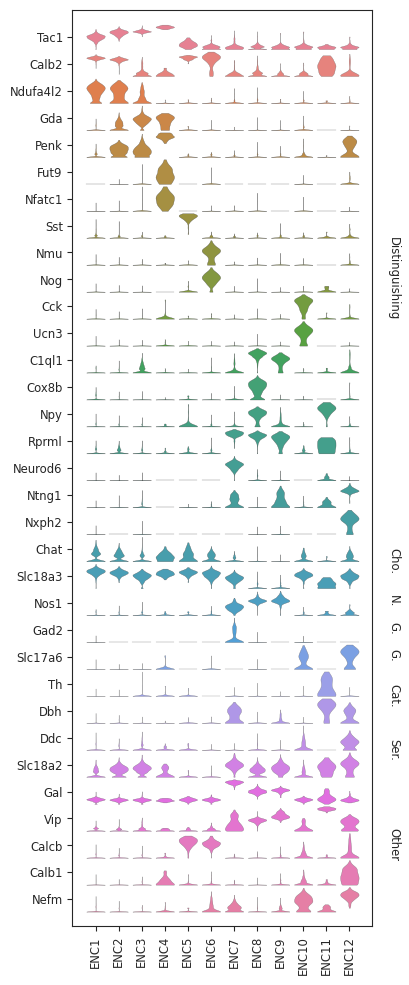

In [128]:
sc.pl.stacked_violin(ad_mn, si_features_dict, row_palette='husl', groupby='celltype', swap_axes=True)

**With Hana's Parameters:**

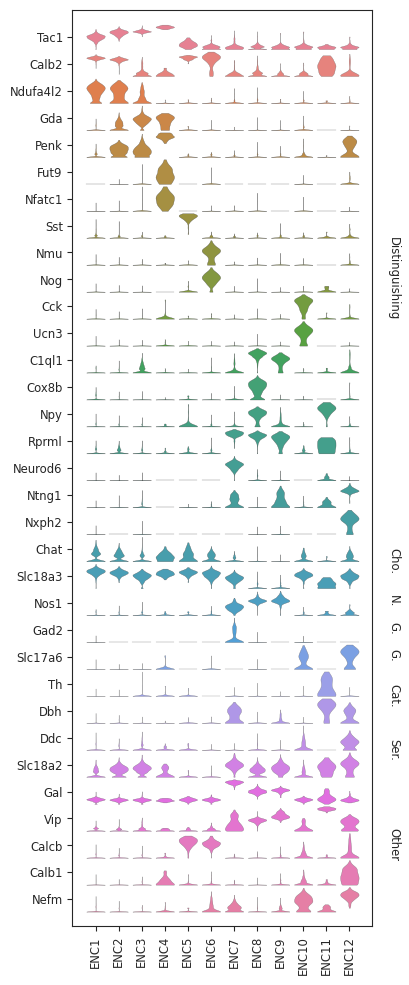

In [226]:
sc.pl.stacked_violin(ad_mn, si_features_dict, row_palette='husl', groupby='celltype', swap_axes=True)

ENC1 = Calb2, Ndufa4l2
ENC2 = Calb2, Gda/Penk, Ndufa4l2
ENC3 = Calb2-, Gda/Penk, Ndufa4l2
ENC4 = Fut9, Gda/Penk, Calb2-
ENC8 = Nos1, Npy, Rprml
ENC9 = Nos1, Npy-, Rprml
ENC10 = Gad2, Neurod6, Rprml
ENC5 = Sst, Calb2, Calcb
ENC6 = Nmu, Calb2, Calcb
ENC7 = Ucn3, Cck, vGlut2
ENC12 = Nxph2, Ntng1, Calb1, vGlut2
ENC11 = Npy, Th, Dbh, Calb2

**Brandon's Parameters:**

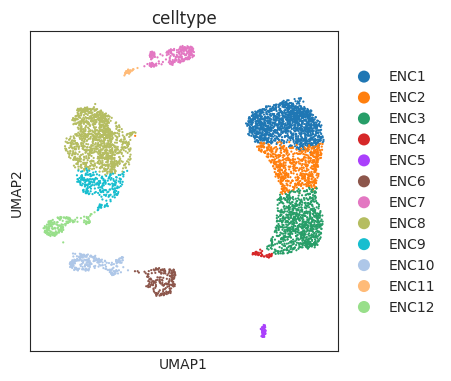

In [90]:
sc.pl.scatter(ad_mn, basis='umap', size=10, color='celltype')

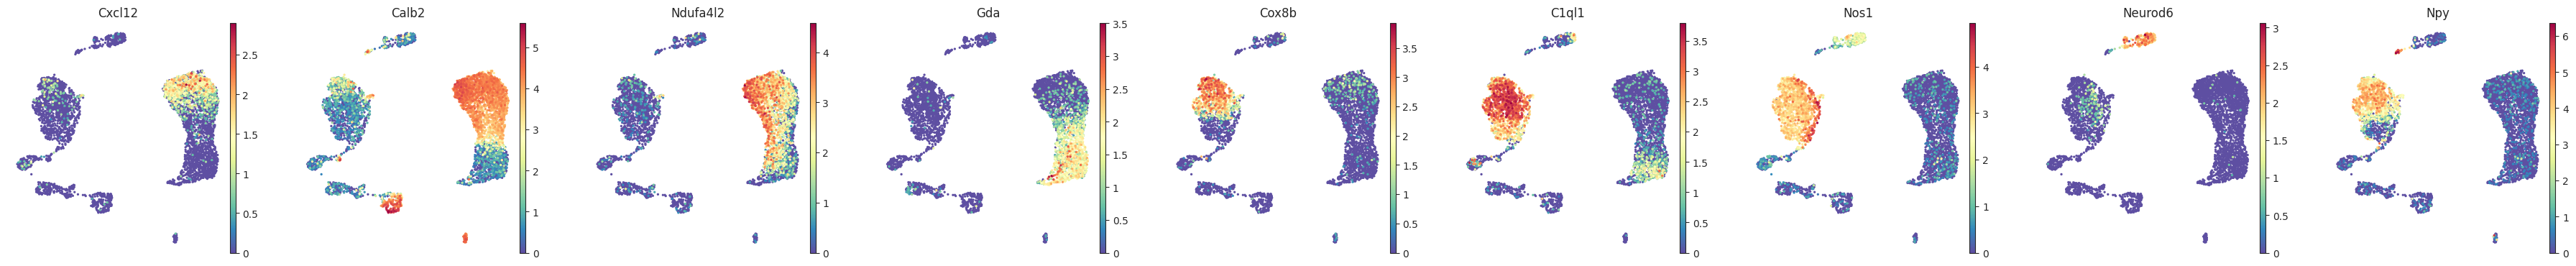

In [91]:
sc.pl.scatter(ad_mn, basis='umap', color=['Cxcl12', 'Calb2', 'Ndufa4l2', 'Gda', 
                                          'Cox8b', 'C1ql1', 'Nos1', 'Neurod6', 'Npy'], frameon=False)

**Check Object**

In [222]:
ad_mn

AnnData object with n_obs × n_vars = 5354 × 18039
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'n_genes', 'n_counts', 'leiden_1.5', 'leiden', 'leiden_0.4', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden_1.5', 'umap', 'tsne', 'leiden_1.5_colors', 'leiden', 'leiden_colors', 'leiden_0.4', 'leiden_0.4_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [223]:
ad_mn.obs 

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,1,1,3,ENC2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,9,10,6,ENC10
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,23,18,9,ENC5
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,2,4,3,ENC2
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,7,4,3,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,28,15,11,ENC11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,1,1,0,ENC1
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,11,2,2,ENC3


### Sanity Check

In [117]:
msi_neurons = sc.read('HM01/myenteric_si_processed.h5ad')

In [118]:
msi_neurons

AnnData object with n_obs × n_vars = 5354 × 18039
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'n_genes', 'n_counts', 'leiden_1.5', 'leiden_1', 'leiden', 'leiden_0.4', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_0.4_colors', 'leiden_1.5_colors', 'leiden_1_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [121]:
msi_neurons.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden_1,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,1,1,2,3,ENC2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,9,11,7,5,ENC7
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,23,20,17,9,ENC5
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,2,7,4,3,ENC2
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,7,17,4,3,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,28,21,15,11,ENC11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,1,0,2,0,ENC1
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,11,3,1,2,ENC3


In [ ]:
subtypes_dict = {
    'NOS': ['Nos1', 'Vip', 'Gal'], # 
    'Chat1/2/3': ['Chat', 'Tac1', 'Penk', 'Met'], #no Penk for Chat1, Met for Chat3 
    'Chat4': ['Slc17a6'],
    'Calcb': ['Calcb', 'Grp', 'Nmu']
}

/Users/hmorris/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


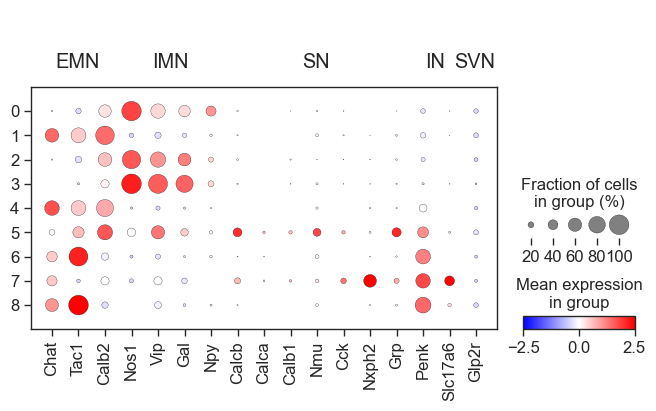

In [128]:
colon = marker_in_set(cn_ad, subtypes_dict)
sc.pl.dotplot(cn_ad, colon, groupby='phenograph',
              layer='scaled',
              vmin=-2.5, vmax=2.5,
              cmap='bwr')

In [79]:
cell_types = pd.Series("", index=cn_ad.obs['phenograph'].values.categories)
cell_types['0'] = 'IMN1' 
cell_types['1'] = 'EMN1' 
cell_types['2'] = 'IMN2'
cell_types['3'] = 'IMN3'
cell_types['4'] = 'EMN2'
cell_types['5'] = 'SN' 
cell_types['6'] = 'IN1'
cell_types['7'] = 'IN/SN' 
cell_types['8'] = 'IN3' 

In [80]:
cn_ad.obs['celltype'] = cell_types[cn_ad.obs['phenograph']].values

/Users/hmorris/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


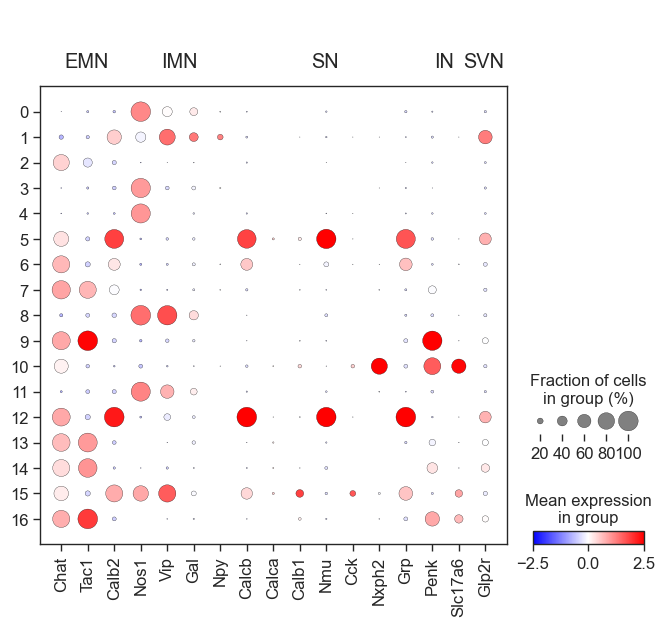

In [130]:
colon = marker_in_set(mli_ad, subtypes_dict)
sc.pl.dotplot(mli_ad, colon, groupby='leiden_1',
              layer='scaled',
              vmin=-2.5, 
              vmax=2.5,
              cmap='bwr'
                )

In [136]:
cell_types = pd.Series("", index=mli_ad.obs['leiden_1'].values.categories)
cell_types['0'] = 'IMN1' 
cell_types['1'] = 'SVN' 
cell_types['2'] = 'EMN1'
cell_types['3'] = 'IMN2'
cell_types['4'] = 'IMN3'
cell_types['5'] = 'SN1' 
cell_types['6'] = 'SN2'
cell_types['7'] = 'EMN2' 
cell_types['8'] = 'IMN4' 
cell_types['9'] = 'IN1'
cell_types['10'] = 'IN3'
cell_types['11'] = 'IMN5'
cell_types['12'] = 'SN1'
cell_types['13'] = 'EMN3'
cell_types['14'] = 'EMN4'
cell_types['15'] = 'SN3'
cell_types['16'] = 'IN3'

In [137]:
mli_ad.obs['celltype'] = cell_types[mli_ad.obs['leiden_1']].values

/Users/hmorris/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


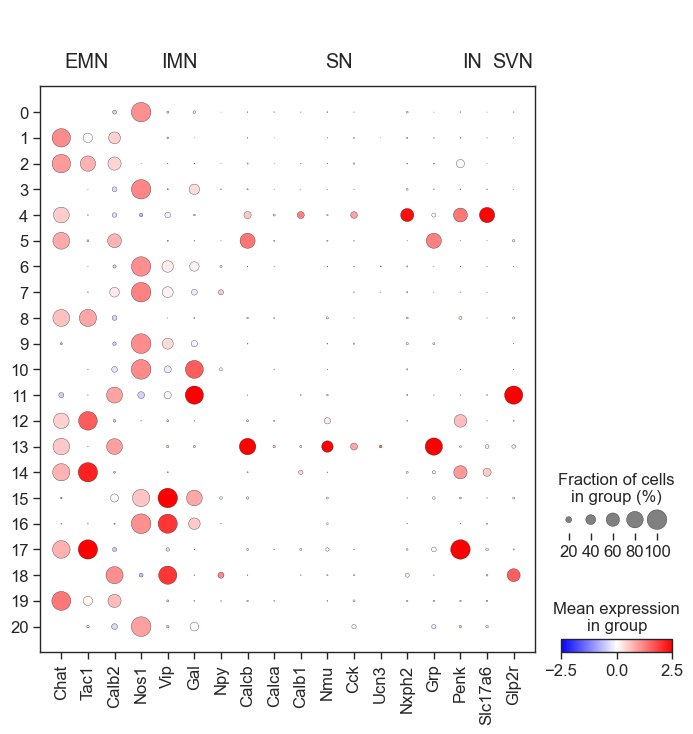

In [112]:
colon = marker_in_set(ss2_ad, subtypes_dict)
sc.pl.dotplot(ss2_ad, colon, groupby='leiden_1',
              layer='scaled',
              vmin=-2.5, 
              vmax=2.5,
              cmap='bwr'
                )

In [119]:
cell_types = pd.Series("", index=ss2_ad.obs['leiden_1'].values.categories)
cell_types['0'] = 'IMN1'
cell_types['1'] = 'EMN1'
cell_types['2'] = 'EMN2'
cell_types['3'] = 'IMN8'
cell_types['4'] = 'SN1'
cell_types['5'] = 'SN2'
cell_types['6'] = 'IMN2'
cell_types['7'] = 'IMN3'
cell_types['8'] = 'EMN4'
cell_types['9'] = 'IMN4'
cell_types['10'] = 'IMN5'
cell_types['11'] = 'SVN1'
cell_types['12'] = 'IN1'
cell_types['13'] = 'SN3'
cell_types['14'] = 'IN2'
cell_types['15'] = 'IMN6'
cell_types['16'] = 'IMN7'
cell_types['17'] = 'IN3'
cell_types['18'] = 'SVN2'
cell_types['19'] = 'EMN5'
cell_types['20'] = 'IMN7'

In [120]:
ss2_ad.obs['celltype'] = cell_types[ss2_ad.obs['leiden_1']].values

## Save Processed Data

In [92]:
# If we want to save the AnnData object:
# ad_mn.write('../results/HM01/myenteric_si_processed.h5ad')